# Disaster Detection from Tweets

## Disaster Tweet Classification

### Context

According to the United Nations, several hundred natural and man-made disasters occur around the world each year. Disasters can result in loss of life and long-term social and environmental consequences, hence the need for efficient disaster response.  

Over the years, social media has proven to be an important channel to access information on disasters and emergencies. AI professionals have explored ways to utilise social media, especially twitter, for effective disaster response strategies.  

By utilizing Deep Learning Techniques to classify user-generated data from Twitter, significant information can be obtained to assist emergency responders in creating effective relief efforts and aiding victims.  

### Objective

The aim for this project is to compare the performance of the combination of word vectorizers - CountVectorizer and TfidfVectorizer with Naive Bayes over word embedding techniques - GloVe and Word2Vec with BiLSTM in classifying disaster tweets as genuine or irrelevant.  

Evaluation metrics such as accuracy, precision, recall and f1-score would be used and the best combination model would be optimized and evaluated.   

### The data 

**id**: Tweet unique identification number  

**keyword**: A disaster-related keyword from the tweet

**location**: The location the tweet was sent from  

**text**: The text of a tweet. Tweets about real disasters and irrelevant information are present in the data.  

**target**: This is a binary label where `1 represents a disaster tweet` and `0 represents a non-disaster tweet`

The data for this project was gotten from Kaggle
https://www.kaggle.com/competitions/nlp-getting-started  

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 13.8 MB/s eta 0:00:00


### Import relevant libraries

The code below imports libraries relevant to completing the tasks in this project.

In [3]:
import re # regex (regular expression) model for text manipulation and pattern mining
import numpy as np  # for numerical computations
from numpy import asarray # to convert an object to a numpy array
from numpy import zeros # to create an array with values of zero 
import pandas as pd  # for data processing
import seaborn as sns  # for data visualisation
import matplotlib.pyplot as plt  # for data visualisation
import nltk # the natural language toolkit for word preprocessing
from nltk.tokenize import word_tokenize # to break sentences into list of words 
from nltk.stem import WordNetLemmatizer # to decompose words to their meaningful base forms
from nltk.corpus import stopwords # to remove stopwords
import string # string module for carrying out some string operations
from wordcloud import WordCloud # for text visualisation
import gensim # for text preprocessing
from gensim.utils import simple_preprocess # for text preprocessing
import contractions # for expanding contracted words 

### Downloading relevant libraries

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Read in the data

The code below:
- Reads in the data using the read_csv method
- Displays 5 randomly selected rows from the dataframe. 

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/train.csv') # reading in the data
data.sample(5) # displaying 5 randomly selected rows

,id,keyword,location,text,target
607,876,bioterror,"Espoo, Finland",USATODAY: On today's #frontpage: #Bioterror la...,1
25,37,NaN,NaN,No way...I can't eat that shit,0
7020,10061,typhoon,Whole World,Global precipitation measurement satellite cap...,1
7101,10174,violent%20storm,NaN,'@NASASolarSystem: Jupiter's Great Red Spot is...,0
529,767,avalanche,"New York, NY",the fall of leaves from a poplar is as fully o...,0


### Data preprocessing

#### Dropping unnecessary columns

The code below:
- Creates a new dataframe by dropping the unnecessary columns ("id", "keyword", "location") in the original dataframe
- Displays 5 randomly selected rows from the dataframe as a quality check.

In [8]:
df = data.drop(["id", "keyword", "location"], axis = 1) # dropping the unnecessary rows
df.sample(5) # displaying 5 randomly selected rows

,text,target
6688,Thunder lightening torrential rain and a power...,1
3061,#earthquake (EMSC): MD 2.9 OFF COAST OF NORTHE...,1
3851,My Gang Walking Round With Them Brown Flames. ...,0
5659,Last Chance Animal Rescue has 3 new posts. htt...,0
4957,@JustinTrudeau \n\nMost respected in world\nBe...,0


#### Data dimension

In [9]:
# checking the dimension of the data
df.shape

(7613, 2)

- There are 7,613 rows and 2 columns in the dataset

#### Cleaning the text

In [10]:
# creating a function to clean the tweet text
def clean_tweet_text(text_column):
    """Function to clean the text in a column
    Args: 
        text_column: the column containing the text to be cleaned
    Returns:
        clean_text: the cleaned tweet text
    """

    # remove contractions
    expanded_text = [contractions.fix(word) for word in text_column.split()]
    text_column = ' '.join(expanded_text)

    text_column = re.sub(r"@[A-Za-z0-9_]+","", text_column) # removes mentions
    text_column = re.sub(r"http\S+", "", text_column) # removes the URLs 
    text_column = re.sub(r"<.*?>", "", text_column) # removes html tags
    text_column = re.sub(r"\d+", "", text_column) # removes numbers
    
    # removes punctuations, converts text to lowercase
    text_column = text_column.translate(str.maketrans("", "", string.punctuation)).lower()
    
    words = nltk.word_tokenize(text_column) # tokenize the text, breaks into individual words
    lemmatizer = WordNetLemmatizer() # creates an instance of the word Lemmatizer
    stop_words = set(stopwords.words("english")) # initializing the stopwords 
    
    # converts words to their base forms and removes stop words and non-ascii words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isascii()]
    
    clean_text = " ".join(words) # join words back into a string
    
    return clean_text

In [11]:
# applying the clean_tweet_text function to the text column
df['clean_text'] = df['text'].apply(clean_tweet_text)

In [12]:
# displaying 10 random rows in the dataset
df.sample(10)

,text,target,clean_text
1183,@followlasg This is urgentthere is currently a...,1,urgentthere currently storey building church b...
4459,Sinjar Massacre Yazidis Blast Lack of Action O...,1,sinjar massacre yazidis blast lack action
2942,Thank you Uplifting spirit. When Im drowned yo...,0,thank uplifting spirit drowned anchor
1156,Japan on Thursday marks the 70th anniversary o...,1,japan thursday mark th anniversary atomic bomb...
2026,The sign-up is open for the FALLING FOR DANGER...,1,signup open falling danger release day blast r...
6495,@silverstar58200 I felt bad for Romero. He car...,0,felt bad romero cared mental stuff sunk career...
5591,The Latest: More homes razed by Northern Calif...,1,latest home razed northern california wildfire
4960,Why must I have a meltdown every few days? ??,0,must meltdown every day
444,Trusting Iran to stop terrorism is like inviti...,0,trusting iran stop terrorism like inviting ars...
3267,Men escape car engulfed in flames in Parley's ...,1,men escape car engulfed flame parley canyon cr...


#### Null Values

In [13]:
# checking for null values
df.isnull().sum()

text          0
target        0
clean_text    0
dtype: int64

- There are no null values in the dataset

#### Duplicated values

In [14]:
# checking for duplicated values
df.duplicated().sum()

92

- There are 92 duplicated values in the dataset. 

In [15]:
# treating the duplicated values
df.drop_duplicates(keep='first', inplace=True)

# reset the index
df.reset_index(drop=True, inplace=True)

In [16]:
# dropping the text column
df.drop('text', axis=1, inplace=True)

In [17]:
# quality check
df.sample(5)

,target,clean_text
7106,0,believe blue isi kwwwkwwwk without weapon blue...
5710,0,recently met discus race relation america amp ...
6356,1,security personnel killed iraq suicide bombing
639,0,yes love
3874,0,w cree led work light bar alloy spot flood com...


In [18]:
# checking the summary information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7521 entries, 0 to 7520
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   target      7521 non-null   int64 
 1   clean_text  7521 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.6+ KB


There are now 7521 rows and 2 columns in the data set

### Exploratory Data Analysis

In [19]:
# getting the percentage distribution of the classes in the target
df.target.value_counts(normalize=True)

0    0.573727
1    0.426273
Name: target, dtype: float64

- The 0 class is 57.4% of the dataset
- The 1 class is approximately 42.6% of the dataset

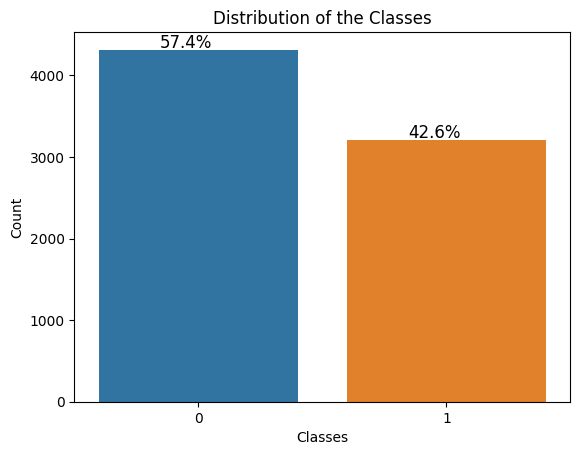

In [20]:
# visualising the distribution of the classes in the target
plot = sns.countplot(data=df, x='target')

data_length = len(df)
    
# Create percentages label for the bars
for p in plot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/data_length) 
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    plot.annotate(percentage, (x, y), ha="center", va = "center", size = 12, xytext = (0, 5), textcoords = "offset points")

plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Distribution of the Classes")
plt.show()

#### Plotting Disaster Tweets

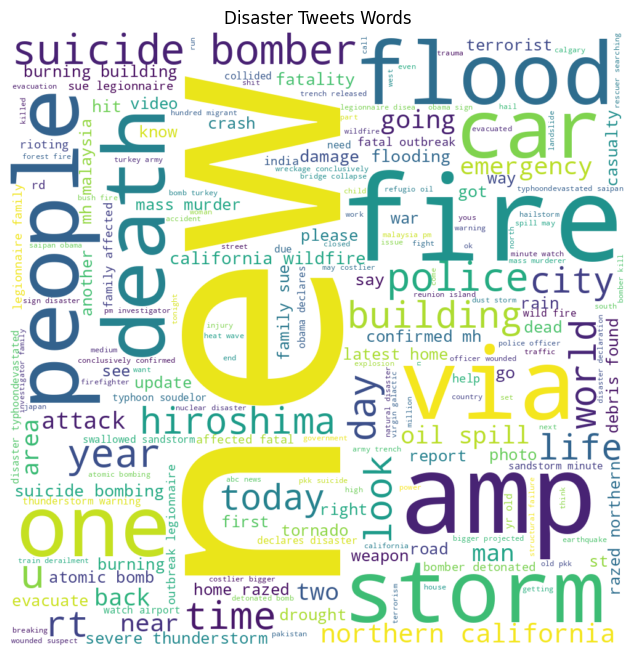

In [ ]:
# converting the disaster tweets to a list of words
dis_tweets = ''
for sent in df[df['target'] == 1]['clean_text'].tolist():
    dis_tweets = dis_tweets + ' ' + sent
    
# instantiate the wordcloud class
wcloud = WordCloud(random_state=0, background_color='white', height=1000, width=1000).generate(dis_tweets)

# show the image
plt.figure(figsize = (8, 8))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Disaster Tweets Words")
plt.show()

From the visualization above, we can clearly see words such as flood, storm, suicide bomber, fire, death etc, all of which are disaster related words.

#### Plotting Non-disaster Tweets

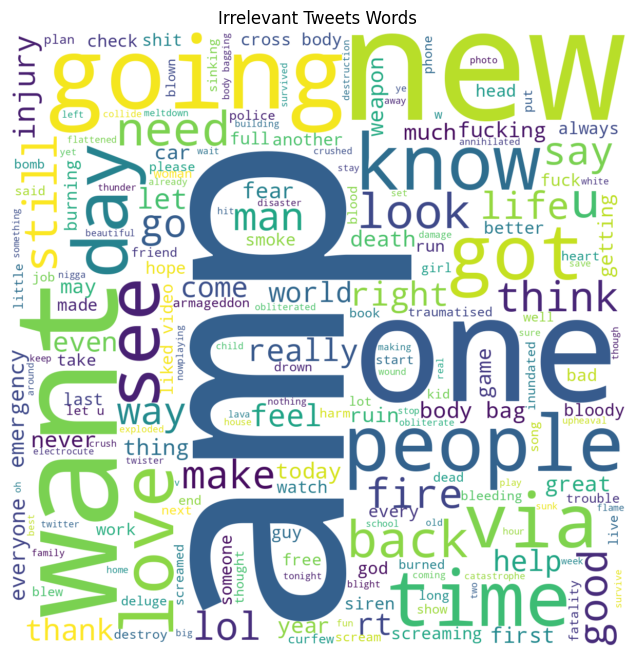

In [ ]:
# converting the irrelevant tweets to a list of words
irr_tweets = ''
for sent in df[df['target'] == 0]['clean_text'].tolist():
    irr_tweets = irr_tweets + ' ' + sent
    
# instantiate the wordcloud class
wcloud = WordCloud(random_state=0, background_color='white', height=1200, width=1200).generate(irr_tweets)

# show the image
plt.figure(figsize = (8, 8))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Irrelevant Tweets Words")
plt.show()

From the visualization above, we can clearly see that most of the words are not disaster related.

### Word Vectorizers

#### Feature Selection

In [ ]:
# feature selection
X = df['clean_text'] # main data is the clean_text column
y = df['target'] # target data if the target column

#### Splitting the data

In [ ]:
# splitting the data into train and test sets

# importing relevant module
from sklearn.model_selection import train_test_split

# splitting the dataset into train and test count vectorizer data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
X_train

6678               photo day storm chaser photography pod
853          dad claim mean right look eye blood xbox smh
2802    potus strategicpatience strategy genocide refu...
6358    remembering rebecca roga philippine murdered h...
2441    killed injured madhya pradesh twin train derai...
                              ...                        
5713    leeds fan rioting embra lower tier league cup ...
1241    fire displaces family damage two building troy...
2687    devastated end longer see tyler blackburn face...
6564                 idek people actually think terrorist
4527    fucking idiot gun amp hatchet yet still seriou...
Name: clean_text, Length: 6016, dtype: object

In [ ]:
X_test

4151    kenya news chelsea talisman eden hazard keen m...
5054     quick fact nuclear reactor come operation u year
5482    dnb newrelease edge jimmy summer rainstorm lap...
274                 feel like pullup one stage apocalypse
982        drake killing dude tea bagging dead body point
                              ...                        
7277    texas seek comment rule change windstorm insur...
5337                  already panicking cry stressed nice
7104                          use weapon might screwed xd
7447    science piece wreckage flight mh confirmed isl...
4675    check deal sivan health fitness basalt lava ho...
Name: clean_text, Length: 1505, dtype: object

In [ ]:
y_train

6678    1
853     0
2802    1
6358    1
2441    1
       ..
5713    1
1241    1
2687    0
6564    0
4527    1
Name: target, Length: 6016, dtype: int64

In [ ]:
y_test

4151    0
5054    0
5482    0
274     0
982     1
       ..
7277    0
5337    0
7104    0
7447    1
4675    0
Name: target, Length: 1505, dtype: int64

In [ ]:
# specifying the number of classes
num_class = len(np.unique(y))
num_class

2

#### Applying the Vectorizers

In [ ]:
# importing the vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# declaring an instance of the vectorizers
count_vect = CountVectorizer(max_features=500)
tfidf_vect = TfidfVectorizer(max_features=500)

# applying the vectorizers
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [ ]:
# converting the data to a dataframe
count_df = pd.DataFrame(X_train_count.toarray(), columns = count_vect.get_feature_names_out())
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf_vect.get_feature_names_out())

In [ ]:
# first 5 rows of the count_df dataframe
count_df.head()

,ablaze,accident,action,actually,affected,air,airplane,airport,also,always,...,would,wound,wounded,wreck,wreckage,wrecked,year,yet,yous,yr
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# first 5 rows of the tfidf_df dataframe
tfidf_df.head()

,ablaze,accident,action,actually,affected,air,airplane,airport,also,always,...,would,wound,wounded,wreck,wreckage,wrecked,year,yet,yous,yr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Functions for Training the Model, Computing Performance Metrics and Plotting the Confusion Matrix

In [ ]:
# importing required metrics
from sklearn.metrics import accuracy_score

In [ ]:
# function to train a model
def train_model(model, X, y):
    """Function to train a model
    Args: 
        model: an instance of the classifier algorithm
        X: the training data
        y: the target data
    Returns:
        trained_model: the trained model
    """
    trained_model = model.fit(X, y) # train the model
    prediction = trained_model.predict(X) # making a prediction
    accuracy = accuracy_score(y, prediction) # computing the train accuracy
    print(f'Train Accuracy: {round(accuracy, 3)}') # printing the train accuracy to 3 d.p
    return trained_model # return the trained model

In [ ]:
# importing relevant modules
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# function to compute model performance
def compute_metrics(trained_model, X, y):
    """Function to compute the performance metrics of a model
    Args:
        trained_model: the trained classifier
        X: the test data
        y: the target data
    Returns:
        y_pred: the predicted values on the test data
    """
    
    y_pred = trained_model.predict(X) # making a prediction
    accuracy = accuracy_score(y, y_pred) # computing the test accuracy
    precision = precision_score(y, y_pred) # computing the precision
    recall = recall_score(y, y_pred) # computing the recall
    f1 = f1_score(y, y_pred) # computing the f1
    
    # printing the metrics
    print(f'Test Accuracy: {round(accuracy, 3)}') # printing test accuracy to 3 decimal places
    print(f'Precision: {round(precision, 3)}') # printing precision to 3 decimal places
    print(f'Recall: {round(recall, 3)}') # printing recall to 3 decimal places
    print(f'F1 Score: {round(f1, 3)}') # printing f1 score to 3 decimal places
    
    return y_pred, accuracy, precision, recall, f1

In [ ]:
# import relevant modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
def plot_conf_mat(trained_model, X, y, y_pred):
    """Function to compute the performance metrics of a model
    Args:
        trained_model: the trained classifier
        X: the test data
        y: the target data
        y_pred: the predicted values on the test data
    """
    labels=['non-disaster','disaster'] 
    conf_mat = confusion_matrix(y, y_pred, labels = [0, 1]) # computing the confusion matrix
    display = ConfusionMatrixDisplay(conf_mat, display_labels=labels) # setting the display 
    display.plot() # plotting the confusion matrix
    plt.show()

    print('\n')
    print(classification_report(y_true=y, y_pred=y_pred,target_names=labels))
    print('\n\n')

#### CountVectorizer and Naive Bayes

In [ ]:
# import Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

# declaring a instance of the classifier class 
mnb_clf = MultinomialNB() 

In [ ]:
# Training the model
count_model = train_model(mnb_clf, X_train_count, y_train)

Train Accuracy: 0.788


In [ ]:
# making predictions and computing metrics
count_pred, count_acc, count_precision, count_recall, count_f1 = compute_metrics(count_model, X_test_count, y_test) 

Test Accuracy: 0.762
Precision: 0.756
Recall: 0.653
F1 Score: 0.701


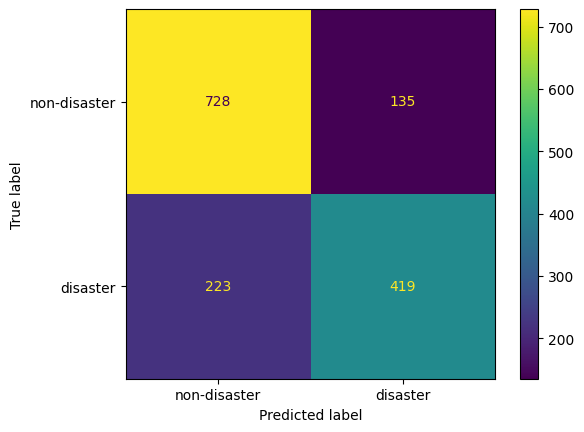



              precision    recall  f1-score   support

non-disaster       0.77      0.84      0.80       863
    disaster       0.76      0.65      0.70       642

    accuracy                           0.76      1505
   macro avg       0.76      0.75      0.75      1505
weighted avg       0.76      0.76      0.76      1505






In [ ]:
# plotting the confusion matrix
plot_conf_mat(count_model, X_test_count, y_test, count_pred)

#### TfidfVectorizer and Naive Bayes

In [ ]:
# Training the model
tfidf_model = train_model(mnb_clf, X_train_tfidf, y_train)

Train Accuracy: 0.79


In [ ]:
# making predictions and computing metrics
tfidf_pred, tfidf_acc, tfidf_precision, tfidf_recall, tfidf_f1 = compute_metrics(tfidf_model, X_test_tfidf, y_test) 

Test Accuracy: 0.765
Precision: 0.778
Recall: 0.629
F1 Score: 0.696


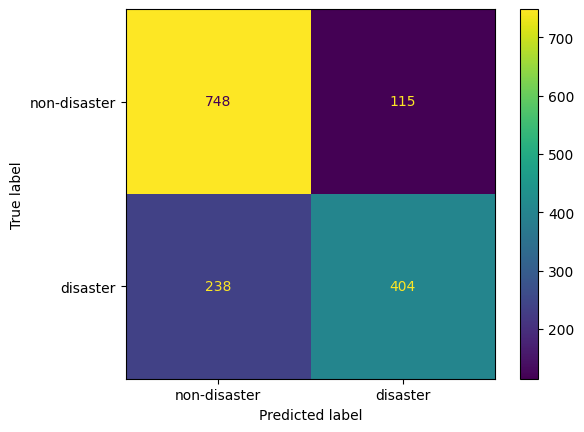



              precision    recall  f1-score   support

non-disaster       0.76      0.87      0.81       863
    disaster       0.78      0.63      0.70       642

    accuracy                           0.77      1505
   macro avg       0.77      0.75      0.75      1505
weighted avg       0.77      0.77      0.76      1505






In [ ]:
# plotting the confusion matrix
plot_conf_mat(tfidf_model, X_test_tfidf, y_test, tfidf_pred)

### Word Embedding Techniques

In [ ]:
# import relevant libraries
import gensim.downloader as downloader
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding, LSTM, GRU, Bidirectional, Input
from tensorflow.keras.optimizers import Adam 
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint

#### Tokenization

In [ ]:
# tokenizing the sentences
tokenized_text = [word_tokenize(line) for line in df['clean_text']] # tokenizing each row of the clean tweet
tokenized_text[0] # getting the text at index 0

['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']

### Word2vec Embedding

In [ ]:
# creating an instance of the Word2vec class
w2v_model = Word2Vec(tokenized_text, vector_size = 100, min_count = 1, workers = 3, window = 3, sg = 1)

In [ ]:
# creating a dictionary that maps each word (key) to its corresponding vector value (value)
w2v_dict = {word:w2v_model.wv.get_vector(word) for word in w2v_model.wv.key_to_index}

In [ ]:
# creating a Word2vec matrix
w2v_matrix = np.zeros((len(w2v_dict), 100)) # creating a matrix to store the vectors for the word embeddings. Assigning zero values to the matrix 

for indx, word in enumerate(w2v_dict): # looping through each word in the dictionary
    if word in w2v_dict:
        w2v_matrix[indx]=w2v_dict[word] # assign the word to its corresponding embedding if found in the dictionary
    else:
        w2v_matrix[indx]=np.random.rand(100) # randomly generate embeddings if word is not found in the dictionary

In [ ]:
# Creating numerical sequences by mapping each word to its corresponding value in the word2vec dictionary

num_seq_w2v = [] # creating an empty list for the numerical sequences
for row in df['clean_text']: # looping through the data
    sequence = [w2v_model.wv.key_to_index[word] for word in row.split() if word in w2v_model.wv.key_to_index] # creating a list of sequences
    num_seq_w2v.append(sequence) # mapping each sequence to the corresponding row in the data

num_seq_w2v[0] # displaying the first row

[4760, 448, 151, 64, 1461, 5346, 12]

In [ ]:
# Padding the sequences to a length equal to the length of the maximum sequence
padding_w2v = pad_sequences(num_seq_w2v, maxlen = max(len(sequence) for sequence in num_seq_w2v), padding = 'post')
padding_w2v[0] # displaying the first row

array([4760,  448,  151,   64, 1461, 5346,   12,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

### GloVe Embedding

In [ ]:
# Downloading the twitter GloVe embeddings
glv_model = downloader.load('glove-twitter-100')

In [ ]:
#create a dictionary that maps each word to its corresponding vector value:
glv_dict = {word:glv_model.get_vector(word) for word in glv_model.key_to_index}

In [ ]:
# creating a GloVe matrix
glv_matrix = np.zeros((len(glv_dict), 100)) # creating a matrix to store the vectors for the word embeddings. Assigning zero values to the matrix 
for indx, word in enumerate(glv_dict): # looping through each word in the dictionary
    if word in glv_dict:
        glv_matrix[indx] = glv_dict[word] # assign the word to its corresponding embedding if found in the dictionary
    else:
        glv_matrix[indx] = np.random.rand(100) # randomly generate embeddings if word is not found in the dictionary


In [ ]:
# Creating numerical sequences by mapping each word to its corresponding value in the word2vec dictionary

num_seq_glv = [] # creating an empty list for the numerical sequences
for row in df['clean_text']: # looping through the data
    sequence = [glv_model.key_to_index[word] for word in row.split() if word in glv_model.key_to_index] # creating a list of sequences
    num_seq_glv.append(sequence) # mapping each sequence to the corresponding row in the data

num_seq_glv[0] # displaying the first row

[21708, 946, 13747, 530, 694, 3836, 51]

In [ ]:
# Padding the sequences to a length equal to the length of the maximum sequence
padding_glv = pad_sequences(num_seq_glv, maxlen = max(len(sequence) for sequence in num_seq_glv), padding = 'post')
padding_glv[0]

array([21708,   946, 13747,   530,   694,  3836,    51,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

# Build model

In [ ]:
# converting the target class to categories

# importing the necessary libraries
from tensorflow.keras.utils import to_categorical

y2 = to_categorical(y) # converting the train target to categories

### BiLSTM and Word2vec

In [ ]:
# splitting the dataset into train and test count vectorizer data
X_train1, X_test1, y_train1, y_test1 = train_test_split(padding_w2v, y2, test_size = 0.2, random_state = 0, stratify = y2)

In [ ]:
es = EarlyStopping(monitor='val_accuracy',
                   min_delta=0.0001,
                   patience=3,
                   verbose=1)
cb = [es]

In [ ]:
# defining the vocabulary size and embedding dimensions
vocab_size = len(w2v_dict)
embedding_dim = 100
max_seq_length = max(len(sequence) for sequence in num_seq_w2v)

# BiLSTM model architecture
model_w2v = Sequential()
model_w2v.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_seq_length, weights = [w2v_matrix], trainable = False))
model_w2v.add(Bidirectional(LSTM(units = 64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)))
model_w2v.add(Bidirectional(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)))
model_w2v.add(Bidirectional(LSTM(units = 256, dropout = 0.2, recurrent_dropout = 0.2)))
model_w2v.add(Dropout(0.3))
model_w2v.add(Dense(units = num_class, activation = 'sigmoid'))

# compiling the model
model_w2v.compile(tf.keras.optimizers.Adam(learning_rate = 3e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_w2v.summary() # model summary

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 100)           1307800   
                                                                 
 bidirectional_6 (Bidirectio  (None, 23, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 23, 256)          263168    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
history_w2v = model_w2v.fit(X_train1, y_train1, epochs = 20, steps_per_epoch = 100, callbacks = cb, batch_size = 32, validation_data = (X_test1, y_test1))


Epoch 1/20
100/100 [==============================] - 37s 245ms/step - loss: 0.6845 - accuracy: 0.5666 - val_loss: 0.6828 - val_accuracy: 0.5734
Epoch 2/20
100/100 [==============================] - 23s 234ms/step - loss: 0.6792 - accuracy: 0.5800 - val_loss: 0.6768 - val_accuracy: 0.5734
Epoch 3/20
100/100 [==============================] - 23s 232ms/step - loss: 0.6689 - accuracy: 0.5925 - val_loss: 0.6415 - val_accuracy: 0.6385
Epoch 4/20
100/100 [==============================] - 23s 233ms/step - loss: 0.6424 - accuracy: 0.6250 - val_loss: 0.6159 - val_accuracy: 0.6352
Epoch 5/20
100/100 [==============================] - 23s 233ms/step - loss: 0.6358 - accuracy: 0.6406 - val_loss: 0.6132 - val_accuracy: 0.6551
Epoch 6/20
100/100 [==============================] - 23s 233ms/step - loss: 0.6289 - accuracy: 0.6506 - val_loss: 0.6058 - val_accuracy: 0.6638
Epoch 7/20
100/100 [==============================] - 23s 233ms/step - loss: 0.6302 - accuracy: 0.6456 - val_loss: 0.6350 - val_ac

### BiLSTM and GloVe

In [ ]:
# splitting the dataset into train and test count vectorizer data
X_train2, X_test2, y_train2, y_test2 = train_test_split(padding_glv, y2, test_size = 0.2, random_state = 0, stratify = y2)

In [ ]:
es = EarlyStopping(monitor='val_accuracy',
                   min_delta=0.0001,
                   patience=3,
                   verbose=1)
cb = [es]

In [ ]:
# defining the vocabulary size and embedding dimensions
vocab_size = len(glv_dict)
embedding_dim = 100
max_seq_length = max(len(sequence) for sequence in num_seq_glv)

# BiLSTM model architecture
model_glv = Sequential()
model_glv.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_seq_length, weights = [glv_matrix], trainable = False))
model_glv.add(Bidirectional(LSTM(units = 64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)))
model_glv.add(Bidirectional(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)))
model_glv.add(Bidirectional(LSTM(units = 256, dropout = 0.2, recurrent_dropout = 0.2)))
model_glv.add(Dropout(0.3))
model_glv.add(Dense(units = num_class, activation = 'sigmoid'))

# Compile the model
model_glv.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_glv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 23, 100)           119351400 
                                                                 
 bidirectional_9 (Bidirectio  (None, 23, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 23, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 512)              1050624   
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
history_glv = model_glv.fit(X_train2, y_train2, epochs = 20, steps_per_epoch = 100, callbacks=cb, batch_size = 32, validation_data = (X_test2, y_test2))

Epoch 1/20
100/100 [==============================] - 36s 247ms/step - loss: 0.5350 - accuracy: 0.7291 - val_loss: 0.4875 - val_accuracy: 0.7654
Epoch 2/20
100/100 [==============================] - 23s 233ms/step - loss: 0.4788 - accuracy: 0.7853 - val_loss: 0.4550 - val_accuracy: 0.8013
Epoch 3/20
100/100 [==============================] - 23s 233ms/step - loss: 0.4591 - accuracy: 0.7912 - val_loss: 0.4475 - val_accuracy: 0.8007
Epoch 4/20
100/100 [==============================] - 23s 234ms/step - loss: 0.4468 - accuracy: 0.8000 - val_loss: 0.4639 - val_accuracy: 0.8040
Epoch 5/20
100/100 [==============================] - 23s 234ms/step - loss: 0.4559 - accuracy: 0.7944 - val_loss: 0.4484 - val_accuracy: 0.7987
Epoch 6/20
100/100 [==============================] - 23s 233ms/step - loss: 0.4298 - accuracy: 0.8184 - val_loss: 0.4578 - val_accuracy: 0.8053
Epoch 7/20
100/100 [==============================] - 23s 234ms/step - loss: 0.4405 - accuracy: 0.8034 - val_loss: 0.4440 - val_ac

# Model evaluation

#### Predictions and Performance Evaluation

In [ ]:
def evaluate_model(trained_model, X, y, model_name):
    """Function to compute the performance metrics of a model
    Args:
        trained_model: the trained neural network
        X: the test data
        y: the target data
        model_name: the name of the model
    """
    
    # plotting the accuracy and loss
    fig, ax = plt.subplots(1, 2, figsize = (12, 5)) # subplot of 1 row and 2 columns
    
    # getting the accuracy and loss
    acc = trained_model.history['accuracy'] # getting the training accuracy values
    val_acc = trained_model.history['val_accuracy'] # getting the validation accuracy values
    loss = trained_model.history['loss'] # getting the training loss values
    val_loss = trained_model.history['val_loss'] # getting the validation loss values
    epochs = range(1, len(acc) + 1) # getting the number of epochs from the length of the accuracy
    
    # plotting the accuracy
    ax[0].plot(epochs, acc, label = 'Training')
    ax[0].plot(epochs, val_acc, label = 'Validation')
    ax[0].legend(loc = 'best')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title(f'{model_name} Accuracy against Epochs')
    
    # plotting the loss
    ax[1].plot(epochs, loss, label = 'Training')
    ax[1].plot(epochs, val_loss, label = 'Validation')
    ax[1].legend(loc = 'best')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title(f'{model_name} Loss against Epochs')
    
    plt.show()

In [ ]:
# function to compute model performance
def compute_metrics(trained_model, X, y, model_name):
    """Function to compute the performance metrics of a model
    Args:
        trained_model: the trained neural network
        X: the test data
        y: the target data
        model_name: the name of the model
    Returns:
        y_pred: the predicted values on the test data
    """
    labels=['non-disaster','disaster']    
    # plotting the confusion matrix
    y_pred = trained_model.predict(X).argmax(axis = 1)
    y=np.argmax(y,axis=1)
    cm = confusion_matrix(y, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels=labels) # setting the display 
    display.plot() # plotting the confusion matrix
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    print('\n')
    print(classification_report(y_true=y, y_pred=y_pred,target_names=labels))
    print('\n\n')

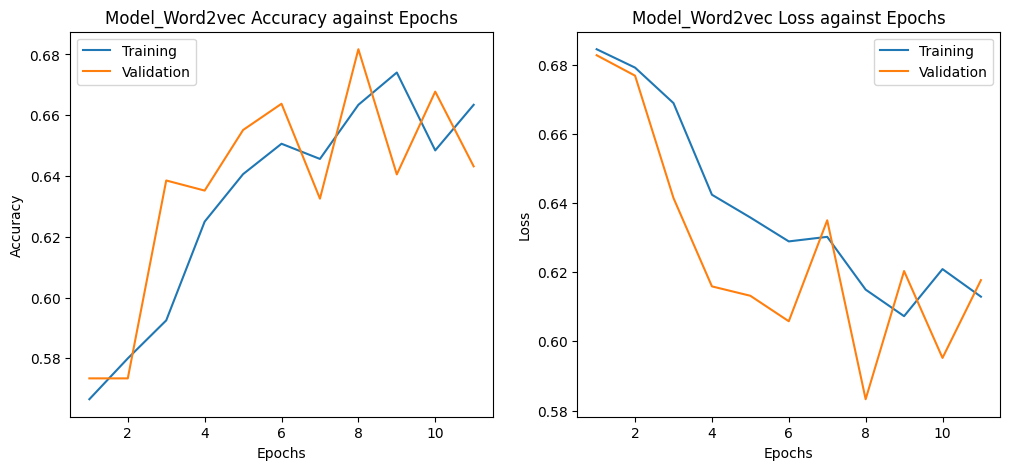

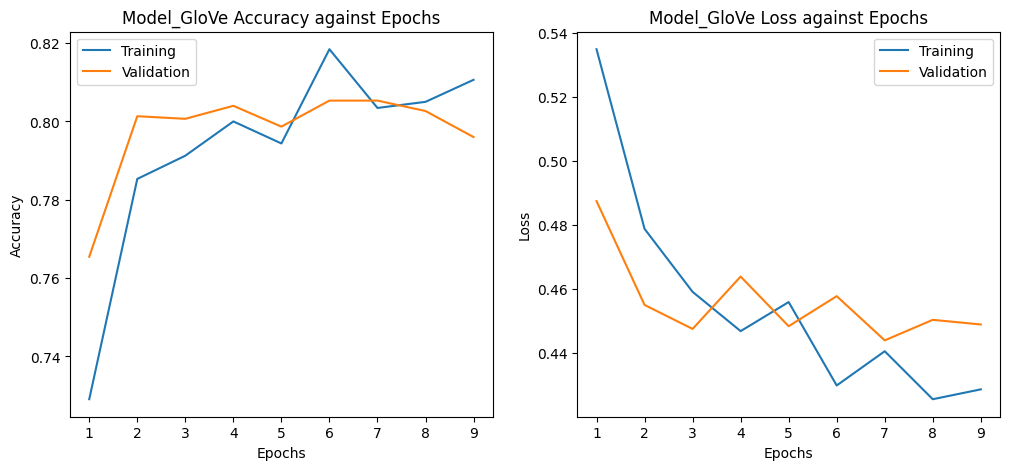

In [ ]:
# evaluating the model
evaluate_model(history_w2v, X_test1, y_test1, 'Model_Word2vec')
evaluate_model(history_glv, X_test2, y_test2, 'Model_GloVe')

48/48 [==============================] - 3s 44ms/step


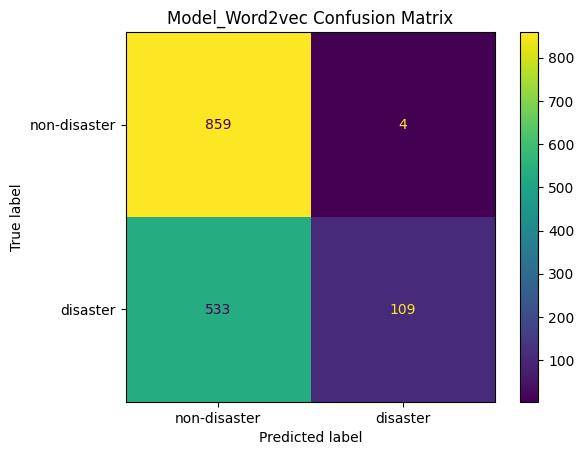



              precision    recall  f1-score   support

non-disaster       0.62      1.00      0.76       863
    disaster       0.96      0.17      0.29       642

    accuracy                           0.64      1505
   macro avg       0.79      0.58      0.53      1505
weighted avg       0.77      0.64      0.56      1505




48/48 [==============================] - 3s 43ms/step


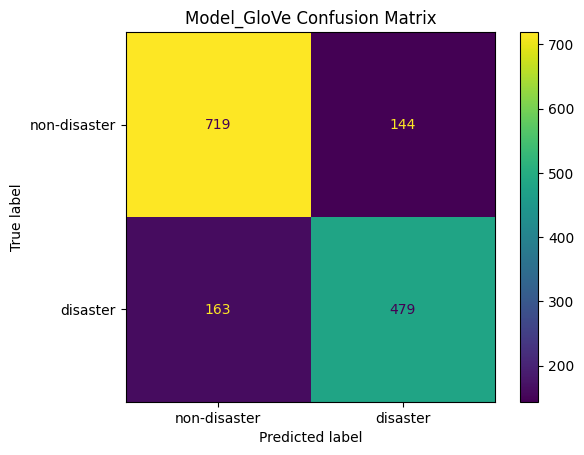



              precision    recall  f1-score   support

non-disaster       0.82      0.83      0.82       863
    disaster       0.77      0.75      0.76       642

    accuracy                           0.80      1505
   macro avg       0.79      0.79      0.79      1505
weighted avg       0.80      0.80      0.80      1505






In [ ]:
compute_metrics(model_w2v,  X_test1, y_test1, 'Model_Word2vec')
compute_metrics(model_glv,  X_test2, y_test2, 'Model_GloVe')

### Model Optimization - Hyperparameter Tuning

In [ ]:
# installing keras-tuner
!pip install keras_tuner 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
# import relevant modules
import keras
import keras_tuner
from kerastuner.tuners import RandomSearch

<ipython-input-84-21c9707b5264>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
# building the Bi-LSTM model and tuning some hyperparameters

def hyper_model(hyper_param):
    """Function to build the bilstm model
    Args:
        hyperParam: 
    Returns:
        model: the trained model
    """
    
    # declaring an instance of the model 
    model = Sequential()

    # adding the embedding layer
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length, weights=[glv_matrix], trainable=False))
  
    # defining the units
    hyper_param_units = hyper_param.Int('units', min_value=32, max_value=256, step=32)
    
    # model architecture
    model.add(Bidirectional(LSTM(units=hyper_param_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=hyper_param_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=256, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_class, activation='sigmoid'))
    
    # compiling the model
    model.compile(optimizer=keras.optimizers.Adam(hyper_param.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4, 5e-4])),
                  loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
# specifying the tuner parameters
tuner = RandomSearch(hyper_model, objective='val_accuracy', max_trials=3, executions_per_trial=3, 
                     directory='/content/drive/MyDrive', project_name='randomsearch_kt')

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy',
                   min_delta = 0.0001,
                   patience = 3,
                   verbose = 1)
cb = [es]

In [ ]:
tuner.search(X_train2, y_train2, epochs=10, validation_data=(X_test2, y_test2), callbacks=cb)

Trial 3 Complete [00h 19m 57s]
val_accuracy: 0.8073089718818665

Best val_accuracy So Far: 0.808194895585378
Total elapsed time: 00h 56m 25s


In [ ]:
# getting the best model
best_model = tuner.get_best_hyperparameters(num_trials=1)[0]
model = hyper_model(best_model)

In [ ]:
es = EarlyStopping(monitor='val_accuracy',
                   min_delta=0.0001,
                   patience=3,
                   verbose=1)
cb = [es]

In [ ]:
# fitting the model
history_best = model.fit(X_train2, y_train2, epochs = 20, steps_per_epoch = 100, callbacks=cb, batch_size = 32, validation_data = (X_test2, y_test2))

Epoch 1/20
100/100 [==============================] - 34s 248ms/step - loss: 0.5418 - accuracy: 0.7391 - val_loss: 0.4731 - val_accuracy: 0.7914
Epoch 2/20
100/100 [==============================] - 24s 237ms/step - loss: 0.4528 - accuracy: 0.8006 - val_loss: 0.4599 - val_accuracy: 0.7927
Epoch 3/20
100/100 [==============================] - 24s 237ms/step - loss: 0.4442 - accuracy: 0.8028 - val_loss: 0.4832 - val_accuracy: 0.7987
Epoch 4/20
100/100 [==============================] - 23s 232ms/step - loss: 0.4550 - accuracy: 0.7959 - val_loss: 0.4499 - val_accuracy: 0.7987
Epoch 5/20
100/100 [==============================] - 24s 236ms/step - loss: 0.4198 - accuracy: 0.8200 - val_loss: 0.4552 - val_accuracy: 0.8013
Epoch 6/20
100/100 [==============================] - 23s 235ms/step - loss: 0.4395 - accuracy: 0.8097 - val_loss: 0.4537 - val_accuracy: 0.8053
Epoch 7/20
100/100 [==============================] - 23s 234ms/step - loss: 0.4227 - accuracy: 0.8078 - val_loss: 0.4437 - val_ac

### Tuned Model Evaluation

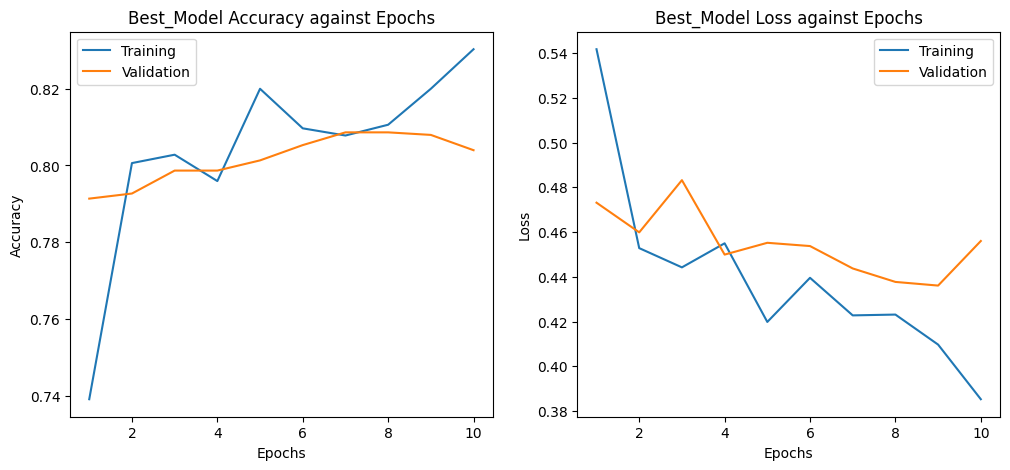

In [ ]:
evaluate_model(history_best, X_test2, y_test2, 'Best_Model')

48/48 [==============================] - 3s 42ms/step


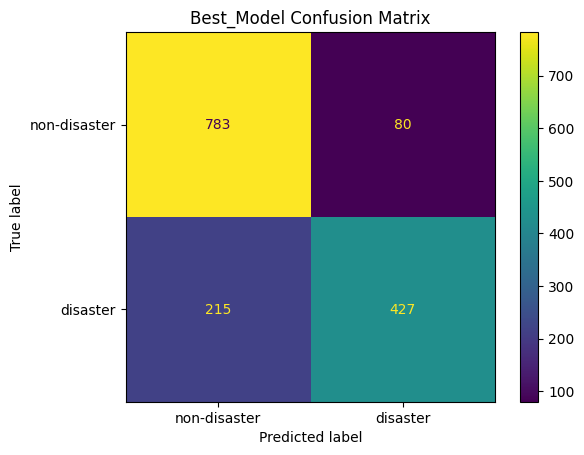



              precision    recall  f1-score   support

non-disaster       0.78      0.91      0.84       863
    disaster       0.84      0.67      0.74       642

    accuracy                           0.80      1505
   macro avg       0.81      0.79      0.79      1505
weighted avg       0.81      0.80      0.80      1505






In [ ]:
compute_metrics(model,  X_test2, y_test2, 'Best_Model')